In [61]:
import numpy as np
import pandas as pd
import scanpy as sc
import igraph

from sklearn.cluster import KMeans
from scipy import stats
from scipy.cluster.hierarchy import dendrogram

import seaborn as sbn
import matplotlib.pyplot as plt

from gprofiler import GProfiler
from sklearn.cluster import KMeans
from natsort import natsorted
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,f1_score


import torch
import torch.nn as nn
import torch.optim as optim

import celltypist

from celltypist import models
import anndata

# Suppress warnings for tidy representation of the notebook   
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
def print_msg(msg_lst: list, sep='\t', color='\033[91m'):
    msg = ""
    for i in msg_lst:
        msg += str(i) + sep

    print(color + "-" * 80 + bcolors.ENDC)
    print(color + msg.center(80, ' ') + bcolors.ENDC)
    print(color + '-' * 80 + bcolors.ENDC)

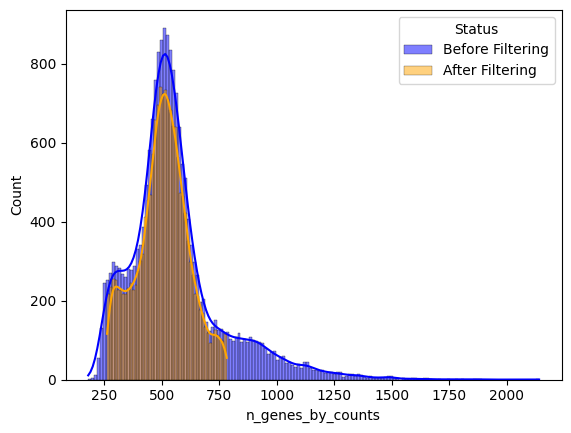

Number of outlier cells is: 2938


In [62]:
# Load the h5ad file
pbmc = sc.read_h5ad('7000-3/Group_13.h5ad')
unknown_pbmc = sc.read_h5ad("7000-3/Test_dataset.h5ad")

# Filter out MT and Ribosomal genes
pbmc.var['mt'] = pbmc.var_names.str.startswith('MT-')
pbmc.var['ribosomal'] = pbmc.var_names.str.startswith(('RPS', "RPL"))
sc.pp.calculate_qc_metrics(pbmc, 
                           qc_vars=['mt', 'ribosomal'], 
                           percent_top=None, 
                           log1p=False, 
                           inplace=True)

unknown_pbmc.var['mt'] = unknown_pbmc.var_names.str.startswith('MT-')
unknown_pbmc.var['ribosomal'] = unknown_pbmc.var_names.str.startswith(('RPS', "RPL"))
sc.pp.calculate_qc_metrics(unknown_pbmc, 
                           qc_vars=['mt', 'ribosomal'], 
                           percent_top=None, 
                           log1p=False, 
                           inplace=True)

# Remove cells with >50% ribosomal content and >5% MT content
pbmc = pbmc[pbmc.obs['pct_counts_ribosomal'] < 50, :]
pbmc = pbmc[pbmc.obs['pct_counts_mt'] < 5, :]
unknown_pbmc = unknown_pbmc[unknown_pbmc.obs['pct_counts_ribosomal'] < 50, :]
unknown_pbmc = unknown_pbmc[unknown_pbmc.obs['pct_counts_mt'] < 5, :]

# Check the effect of data preprocessing, notice the change to the normal distribution
sbn.histplot(pbmc.obs.n_genes_by_counts, color = "blue", label = "Before Filtering", kde = True)

gene_counts = pbmc.obs["n_genes_by_counts"].tolist()
median_gene_counts = np.median(gene_counts)
mad_gene_counts = np.median(np.abs(gene_counts - median_gene_counts))

# Get the upper and lower bound
lower_bound_gene = median_gene_counts - 3 * mad_gene_counts
upper_bound_gene = median_gene_counts + 3 * mad_gene_counts
outlier_cells_number = np.sum(gene_counts < lower_bound_gene) + np.sum(gene_counts > upper_bound_gene)

# Remove outlier gene based on the upper and lower bound
pbmc = pbmc[pbmc.obs.n_genes_by_counts > lower_bound_gene, :]
new_pbmc = pbmc[pbmc.obs.n_genes_by_counts < upper_bound_gene, :]

sbn.histplot(new_pbmc.obs.n_genes_by_counts, color = "orange", label = "After Filtering", kde=True)
plt.legend(title = "Status")
plt.show()

print("Number of outlier cells is:", outlier_cells_number)

# filter genes Minimum of 3 cells *WHY 3 CELLS
sc.pp.filter_genes(new_pbmc, min_cells=3)

# Normalize
sc.pp.normalize_total(new_pbmc, target_sum = None, inplace=True)
sc.pp.log1p(new_pbmc)

# Selection of highly variable genes selection
sc.pp.highly_variable_genes(new_pbmc, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pp.scale(new_pbmc)
new_pbmc = new_pbmc[:, new_pbmc.var['highly_variable']]

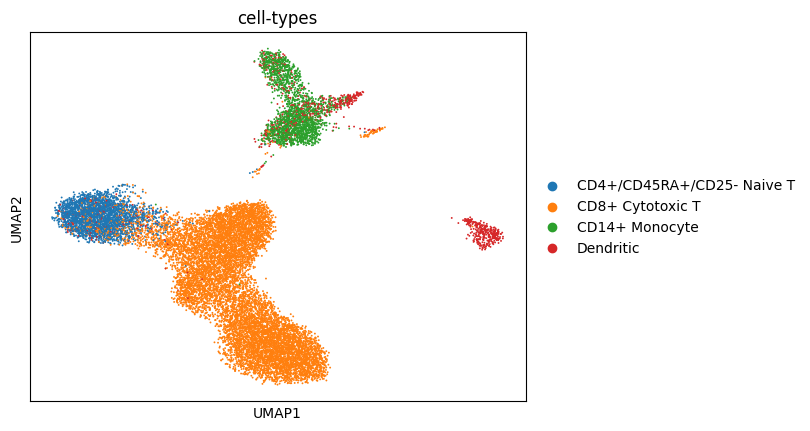

In [63]:
sc.tl.pca(new_pbmc, svd_solver="arpack")
sc.pp.neighbors(new_pbmc, n_neighbors=15, n_pcs=40)
sc.tl.umap(new_pbmc)
sc.pl.umap(new_pbmc, color=['cell-types'])  # Color by cell type

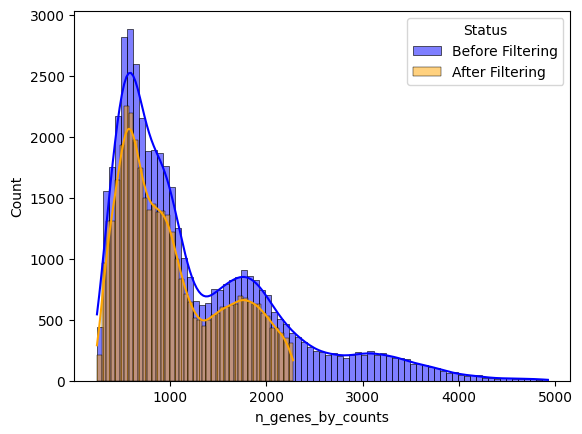

Number of outlier cells is: 5639


In [64]:
sbn.histplot(unknown_pbmc.obs.n_genes_by_counts, color = "blue", label = "Before Filtering", kde = True)

gene_counts = unknown_pbmc.obs["n_genes_by_counts"].tolist()
median_gene_counts = np.median(gene_counts)
mad_gene_counts = np.median(np.abs(gene_counts - median_gene_counts))

# Get the upper and lower bound
lower_bound_gene = median_gene_counts - 3 * mad_gene_counts
upper_bound_gene = median_gene_counts + 3 * mad_gene_counts

# Remove outlier gene based on the upper and lower bound
unknown_pbmc = unknown_pbmc[unknown_pbmc.obs.n_genes_by_counts > lower_bound_gene, :]
unknown_pbmc = unknown_pbmc[unknown_pbmc.obs.n_genes_by_counts < upper_bound_gene, :]
outlier_cells_number = np.sum(gene_counts < lower_bound_gene) + np.sum(gene_counts > upper_bound_gene)

sbn.histplot(unknown_pbmc.obs.n_genes_by_counts, color = "orange", label = "After Filtering", kde=True)
plt.legend(title = "Status")
plt.show()


# filter genes Minimum of 3 cells *WHY 3 CELLS
sc.pp.filter_genes(unknown_pbmc, min_cells=3)
print("Number of outlier cells is:", outlier_cells_number)

In [65]:
mapping_dict = {
    "CD4+ T cell": "CD4+/CD45RA+/CD25- Naive T",
    "CD8+ T cell": "CD8+ Cytotoxic T",
    "CD14+ Monocyte": "CD14+ Monocyte",
    "cDC": "Dendritic",
    "pDC": "Dendritic"
}
cell_types_to_filter = ['CD4+/CD45RA+/CD25- Naive T', 
                        "CD8+ Cytotoxic T", 
                        "CD14+ Monocyte", 
                        "Dendritic"]

unknown_pbmc.obs['cell-types'] = unknown_pbmc.obs['cell-types'].map(mapping_dict)

mask = unknown_pbmc.obs['cell-types'].isin(cell_types_to_filter)
unknown_pbmc = unknown_pbmc[mask]

sc.pp.normalize_total(unknown_pbmc, target_sum = None, inplace=True)
sc.pp.log1p(unknown_pbmc)
sc.pp.scale(unknown_pbmc)

In [66]:
unknown_pbmc.obs["cell-types"] == "CD14+ Monocyte"

index
Schulte-Schrepping-48266    False
Schulte-Schrepping-48267    False
Schulte-Schrepping-48268     True
Schulte-Schrepping-48269     True
Schulte-Schrepping-48270     True
                            ...  
Schulte-Schrepping-99044    False
Schulte-Schrepping-99045     True
Schulte-Schrepping-99046    False
Schulte-Schrepping-99047    False
Schulte-Schrepping-99048    False
Name: cell-types, Length: 28941, dtype: bool

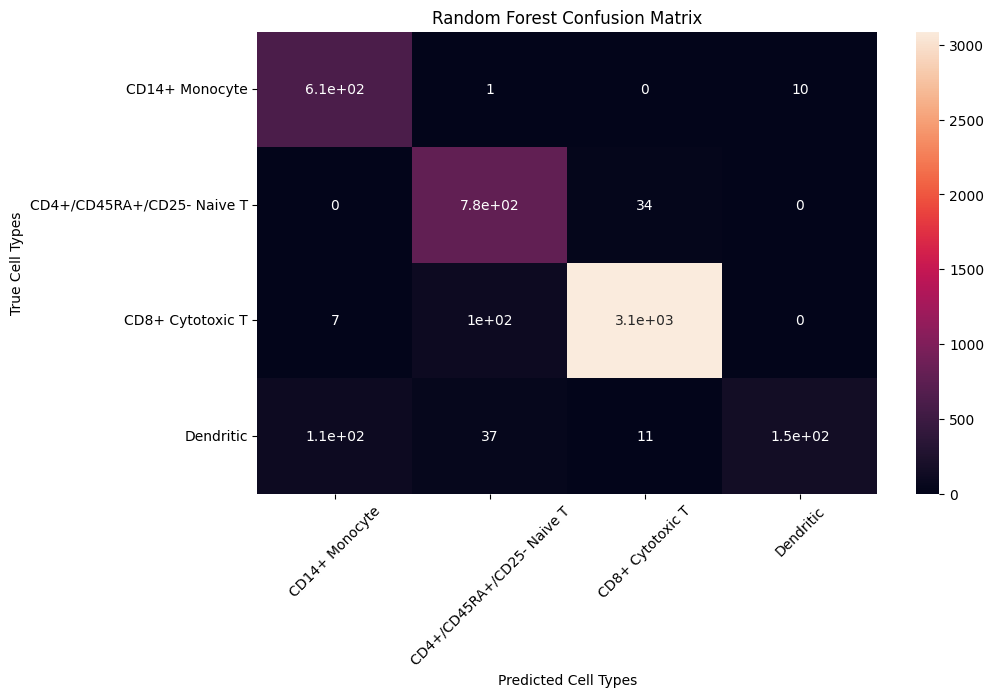

test 0.9371833839918946


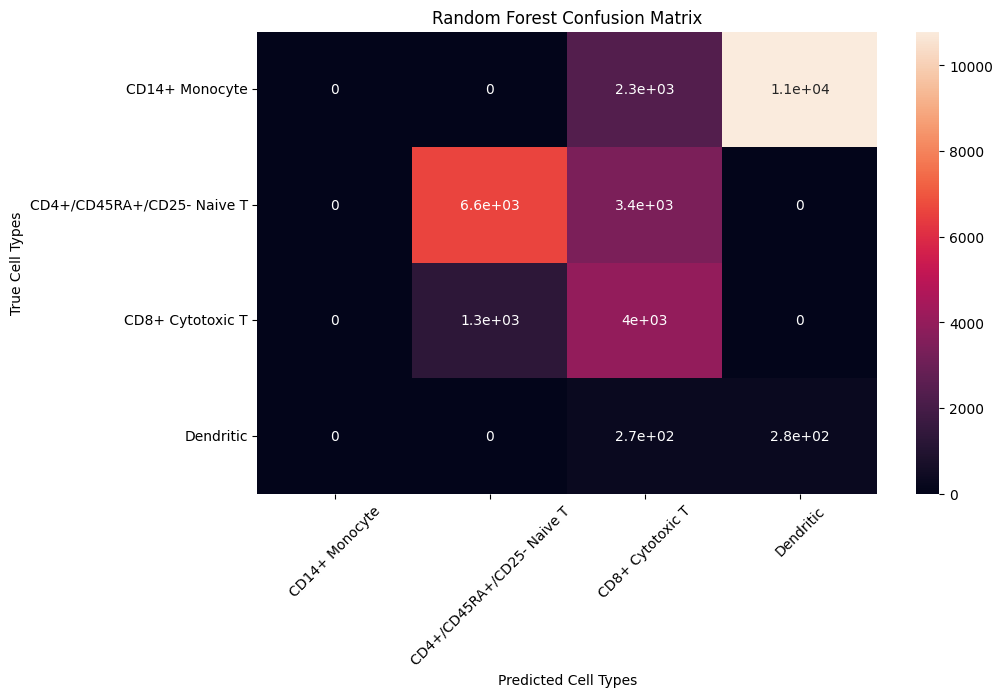

0.37534984969420543
F1 Score 0.326999556614959


In [67]:
# extract X and y
X = new_pbmc.obsm["X_umap"]  # features (PCA components)
y = new_pbmc.obs['cell-types']  # labels (cell tyapes)

# encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [10, 20, 50, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None]
# }
# 
# rf = RandomForestClassifier(random_state=42)
# 
# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
# 
# # Fit the grid search model
# grid_search.fit(X, y)
# 
# # Get the best parameters
# print(f'Best parameters: {grid_search.best_params_}')
# print(f'Best cross-validated score: {grid_search.best_score_}')

# Best Parameter is :
# Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

rf = RandomForestClassifier(n_estimators=200, 
                            max_depth= 10,
                            max_features= 'sqrt',
                            min_samples_leaf= 4,
                            min_samples_split= 10)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
labels = list(encoder.classes_)
cm = confusion_matrix(y_test, y_pred, )

plt.figure(figsize=(10, 6))
sbn.heatmap(cm, annot=True, 
            xticklabels = np.unique(labels), 
            yticklabels = np.unique(labels))
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Cell Types")
plt.ylabel("True Cell Types")
plt.tick_params(axis = 'x', rotation = 45)

# Show the plot
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print("test", accuracy)


unknown_X = unknown_pbmc.obsm["X_umap"]
unknown_y = unknown_pbmc.obs["cell-types"]
unknown_y = encoder.transform(unknown_y)

y_pred = rf.predict(unknown_X)

cm = confusion_matrix(unknown_y, y_pred, )

labels = list(encoder.classes_)

plt.figure(figsize=(10, 6))
sbn.heatmap(cm, annot=True, 
            xticklabels = np.unique(labels), 
            yticklabels = np.unique(labels))
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Cell Types")
plt.ylabel("True Cell Types")
plt.tick_params(axis = 'x', rotation = 45)

# Show the plot
plt.show()

accuracy = accuracy_score(unknown_y, y_pred)
print(accuracy)
print("F1 Score", f1_score(unknown_y, y_pred,average='macro'))


SVM Accuracy: 0.48


<Figure size 1000x600 with 0 Axes>

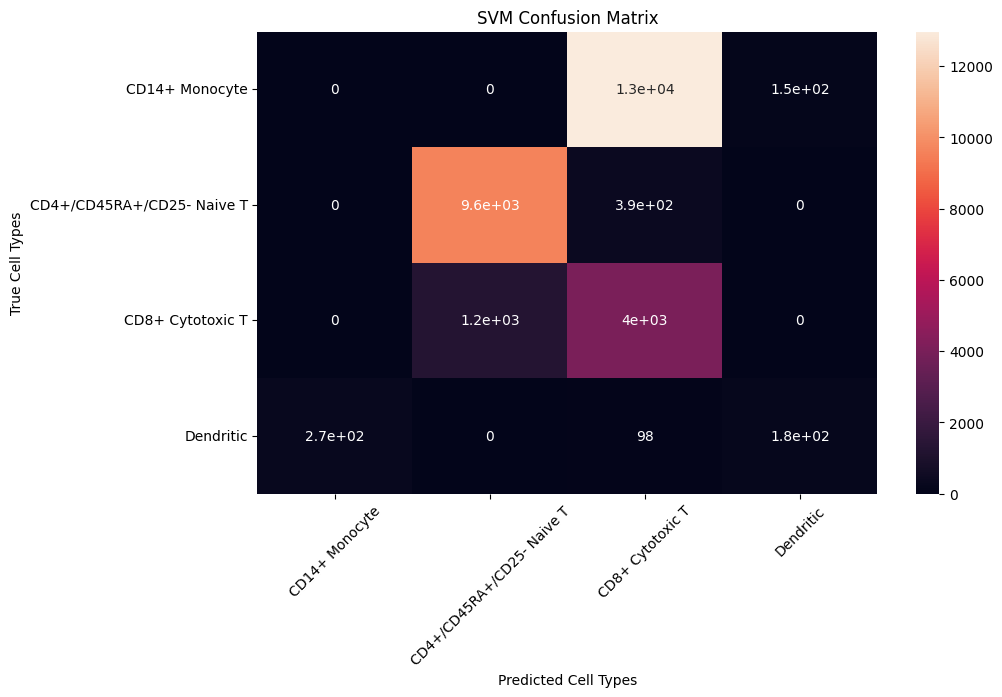

0.4782142980546629
F1 Score 0.4230411267959615


In [68]:
from sklearn.svm import SVC

# Train Support Vector Machine Classifier
svm = SVC(kernel='linear', random_state=42)
svm.fit(X, y)
y_pred_svm = svm.predict(unknown_X)
svm_accuracy = accuracy_score(unknown_y, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.2f}")

cm = confusion_matrix(unknown_y, y_pred_svm)

plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
sbn.heatmap(cm, annot=True, 
            xticklabels = np.unique(labels), 
            yticklabels = np.unique(labels))

plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Cell Types")
plt.ylabel("True Cell Types")
plt.tick_params(axis = 'x', rotation = 45)

# Set labels and Title
plt.title("SVM Confusion Matrix")

# Show the plot
plt.show()

print(svm_accuracy)
print("F1 Score", f1_score(unknown_y, y_pred_svm,average='macro'))



In [69]:
# Perform differential expression analysis comparing CD8 cells to all others
sc.tl.rank_genes_groups(new_pbmc, groupby='cell-types', groups=['CD8+ Cytotoxic T'], reference='rest', method='t-test')


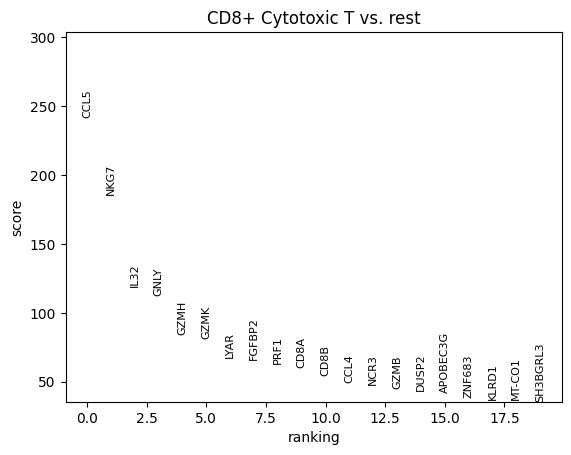

Top genes specifically expressed in CD8 cells: ['CCL5' 'NKG7' 'IL32' 'GNLY' 'GZMH' 'GZMK' 'LYAR' 'FGFBP2' 'PRF1' 'CD8A'
 'CD8B' 'CCL4' 'NCR3' 'GZMB' 'DUSP2' 'APOBEC3G' 'ZNF683' 'KLRD1' 'MT-CO1'
 'SH3BGRL3']


In [70]:
sc.tl.rank_genes_groups(new_pbmc, groupby='cell-types', 
                        groups=['CD8+ Cytotoxic T'], 
                        reference='rest', 
                        method='t-test')
sc.pl.rank_genes_groups(new_pbmc, n_genes=20, sharey=False)
# Get the names of the top marker genes for CD8 cells
cd8_genes = new_pbmc.uns['rank_genes_groups']['names']['CD8+ Cytotoxic T']

# Print the top genes for CD8 cells
print(f"Top genes specifically expressed in CD8 cells: {cd8_genes[:20]}")

In [71]:
# Access the log-fold change and p-values
logfoldchanges = new_pbmc.uns['rank_genes_groups']['logfoldchanges']['CD8+ Cytotoxic T']
pvals_adj = new_pbmc.uns['rank_genes_groups']['pvals_adj']['CD8+ Cytotoxic T']

# Filter for significant genes (adjust the threshold as needed)
significant_genes = cd8_genes[(logfoldchanges > 1) & (pvals_adj < 0.05)]

print(f"Significant genes specifically expressed in CD8 cells: {significant_genes}")


Significant genes specifically expressed in CD8 cells: []


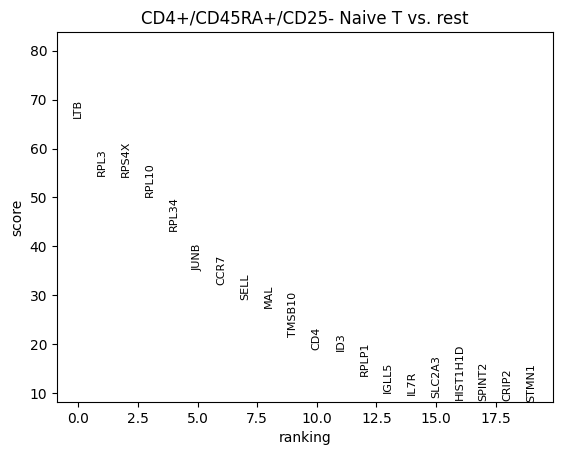

Top genes specifically expressed in CD4 cells: ['LTB' 'RPL3' 'RPS4X' 'RPL10' 'RPL34' 'JUNB' 'CCR7' 'SELL' 'MAL' 'TMSB10'
 'CD4' 'ID3' 'RPLP1' 'IGLL5' 'IL7R' 'SLC2A3' 'HIST1H1D' 'SPINT2' 'CRIP2'
 'STMN1']


In [72]:
sc.tl.rank_genes_groups(new_pbmc, groupby='cell-types', 
                        groups=['CD4+/CD45RA+/CD25- Naive T'], 
                        reference='rest', 
                        method='t-test')
sc.pl.rank_genes_groups(new_pbmc, n_genes=20, sharey=False)
# Get the names of the top marker genes for CD8 cells
cd8_genes = new_pbmc.uns['rank_genes_groups']['names']['CD4+/CD45RA+/CD25- Naive T']

# Print the top genes for CD8 cells
print(f"Top genes specifically expressed in CD4 cells: {cd8_genes[:20]}")

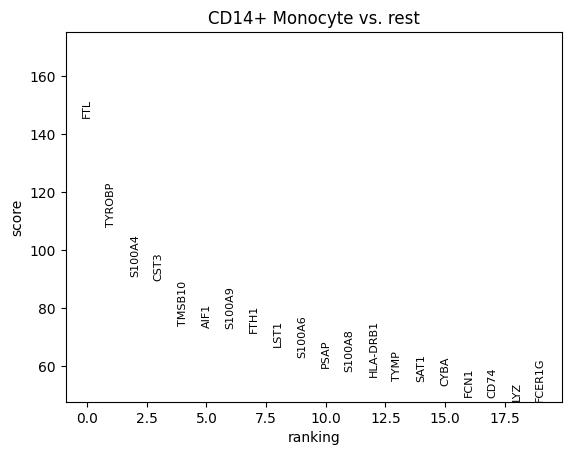

Top genes specifically expressed in Monocytes cells: ['FTL' 'TYROBP' 'S100A4' 'CST3' 'TMSB10' 'AIF1' 'S100A9' 'FTH1' 'LST1'
 'S100A6' 'PSAP' 'S100A8' 'HLA-DRB1' 'TYMP' 'SAT1' 'CYBA' 'FCN1' 'CD74'
 'LYZ' 'FCER1G']


In [73]:
sc.tl.rank_genes_groups(new_pbmc, groupby='cell-types', 
                        groups=['CD14+ Monocyte'], 
                        reference='rest', 
                        method='t-test')
sc.pl.rank_genes_groups(new_pbmc, n_genes=20, sharey=False)
# Get the names of the top marker genes for CD8 cells
cd8_genes = new_pbmc.uns['rank_genes_groups']['names']['CD14+ Monocyte']

# Print the top genes for CD8 cells
print(f"Top genes specifically expressed in Monocytes cells: {cd8_genes[:20]}")

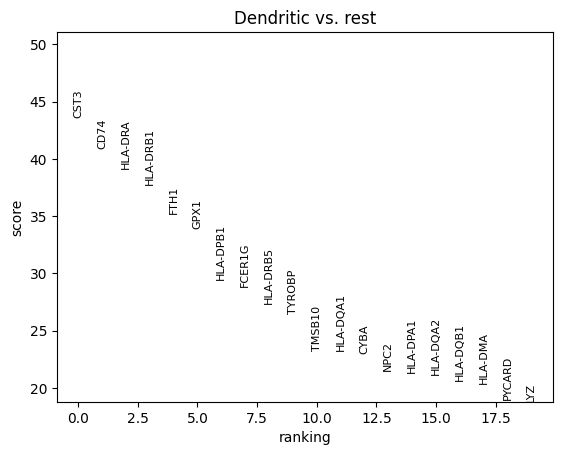

Top genes specifically expressed in Monocytes cells: ['CST3' 'CD74' 'HLA-DRA' 'HLA-DRB1' 'FTH1' 'GPX1' 'HLA-DPB1' 'FCER1G'
 'HLA-DRB5' 'TYROBP' 'TMSB10' 'HLA-DQA1' 'CYBA' 'NPC2' 'HLA-DPA1'
 'HLA-DQA2' 'HLA-DQB1' 'HLA-DMA' 'PYCARD' 'LYZ']


In [74]:
sc.tl.rank_genes_groups(new_pbmc, groupby='cell-types', 
                        groups=['Dendritic'], 
                        reference='rest', 
                        method='t-test')
sc.pl.rank_genes_groups(new_pbmc, n_genes=20, sharey=False)
# Get the names of the top marker genes for CD8 cells
cd8_genes = new_pbmc.uns['rank_genes_groups']['names']['Dendritic']

# Print the top genes for CD8 cells
print(f"Top genes specifically expressed in Monocytes cells: {cd8_genes[:20]}")